In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Installation

In [2]:
!pip install ultralytics --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.4 MB/s eta 0:00:0000:0100:01


# Creating YAML

In [3]:
import yaml

 
fixed_data = {
    'train': '/kaggle/input/solidworks-ai-hackathon/yolo_dataset/yolo_dataset/images/train',
    'val': '/kaggle/input/solidworks-ai-hackathon/yolo_dataset/yolo_dataset/images/val',
    'test': '/kaggle/input/solidworks-ai-hackathon/yolo_dataset/yolo_dataset/images/test',
    'nc': 4,
    'names': ['bolt', 'locatingpin', 'nut', 'washer']
}

 
fixed_yaml_path = '/kaggle/working/dataset_fixed.yaml'
with open(fixed_yaml_path, 'w') as f:
    yaml.dump(fixed_data, f)

print("Corrected YAML created at:", fixed_yaml_path)

Corrected YAML created at: /kaggle/working/dataset_fixed.yaml


# Data Pre-processing and Insights

In [2]:
import pandas as pd

labels = pd.read_csv("/kaggle/input/solidworksnew/train_labels.csv")
bboxes = pd.read_csv("/kaggle/input/solidworksnew/train_bboxes.csv")


print("Images:", labels.shape[0])
print("Bounding boxes:", bboxes.shape[0])
print("Avg boxes per image:", bboxes.shape[0] / labels.shape[0])


Images: 10000
Bounding boxes: 24982
Avg boxes per image: 2.4982


In [3]:
labels["total_objects"] = labels[["bolt","locatingpin","nut","washer"]].sum(axis=1)
labels["total_objects"].value_counts().sort_index()


total_objects
1    2521
2    2513
3    2429
4    2537
Name: count, dtype: int64

In [4]:
import itertools

pairs = {}
for a, b in itertools.combinations(["bolt","locatingpin","nut","washer"], 2):
    pairs[f"{a}+{b}"] = ((labels[a] > 0) & (labels[b] > 0)).mean()

pd.Series(pairs).sort_values(ascending=False)


nut+washer            0.2110
bolt+washer           0.2099
locatingpin+washer    0.2074
bolt+locatingpin      0.2056
bolt+nut              0.2055
locatingpin+nut       0.1998
dtype: float64

In [5]:
bboxes["width"] = bboxes["x_max"] - bboxes["x_min"]
bboxes["height"] = bboxes["y_max"] - bboxes["y_min"]
bboxes["area"] = bboxes["width"] * bboxes["height"]
bboxes["aspect_ratio"] = bboxes["width"] / bboxes["height"]

bboxes.groupby("class")[["area","aspect_ratio"]].describe()



area                                                    \
              count     mean  std      min      25%      50%      75%   
class                                                                   
bolt         6229.0  50176.0  0.0  50176.0  50176.0  50176.0  50176.0   
locatingpin  6185.0  50176.0  0.0  50176.0  50176.0  50176.0  50176.0   
nut          6134.0  50176.0  0.0  50176.0  50176.0  50176.0  50176.0   
washer       6434.0  50176.0  0.0  50176.0  50176.0  50176.0  50176.0   

                     aspect_ratio                                     
                 max        count mean  std  min  25%  50%  75%  max  
class                                                                 
bolt         50176.0       6229.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  
locatingpin  50176.0       6185.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  
nut          50176.0       6134.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  
washer       50176.0       6434.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0

In [6]:
bboxes.groupby("image_name").size().describe()


count    10000.000000
mean         2.498200
std          1.123264
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max          4.000000
dtype: float64

In [7]:
bboxes["xc"] = (bboxes["x_min"] + bboxes["x_max"]) / 2
bboxes["yc"] = (bboxes["y_min"] + bboxes["y_max"]) / 2

bboxes[["xc","yc"]].describe()


,xc,yc
count,24982.000000,24982.000000
mean,511.798255,511.334241
std,252.004963,252.004164
min,260.000000,260.000000
25%,260.000000,260.000000
50%,260.000000,260.000000
75%,764.000000,764.000000
max,764.000000,764.000000


In [8]:
bboxes.groupby(pd.cut(bboxes["xc"], bins=4)).size()
bboxes.groupby(pd.cut(bboxes["yc"], bins=4)).size()


/tmp/ipykernel_55/1082997209.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bboxes.groupby(pd.cut(bboxes["xc"], bins=4)).size()
/tmp/ipykernel_55/1082997209.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bboxes.groupby(pd.cut(bboxes["yc"], bins=4)).size()


yc
(259.496, 386.0]    12524
(386.0, 512.0]          0
(512.0, 638.0]          0
(638.0, 764.0]      12458
dtype: int64

In [9]:
# Impossible cases
labels[
    (labels[["bolt","locatingpin","nut","washer"]] > 1).any(axis=1)
].head()


,image_name,bolt,locatingpin,nut,washer,total_objects
1,6a9f5545730c4311b55c501997fad81e.png,2,0,0,0,2
2,d75f90e50ddb431f86f32958ac23da2d.png,1,2,0,1,4
3,a77b7e1fb75e447faded60b3f55ce1c0.png,1,1,2,0,4
7,eda1897d34c746168d698d82c0e332c0.png,0,0,2,0,2
8,be808b6b65f042d6993942308d81be59.png,1,2,0,0,3


In [10]:
labels["total_objects"].value_counts(normalize=True)


total_objects
4    0.2537
1    0.2521
2    0.2513
3    0.2429
Name: proportion, dtype: float64

In [11]:
# Simulate 1 wrong class
import numpy as np

correct = labels.copy()
wrong = correct.copy()

idx = np.random.choice(len(wrong), size=3, replace=False)
wrong.loc[idx, "nut"] += 1
wrong.loc[idx, "washer"] -= 1

accuracy = (correct == wrong).all(axis=1).mean()
accuracy


np.float64(0.9997)

In [12]:
print("Unique image resolutions:",
      set([(1024,1024)]))


Unique image resolutions: {(1024, 1024)}


In [16]:
import os 
label_dir = "/kaggle/input/solidworks-ai-hackathon/yolo_dataset/yolo_dataset/labels/train"

sample = os.listdir(label_dir)[0]
with open(os.path.join(label_dir, sample)) as f:
    print(f.read())


3 0.253906 0.746094 0.218750 0.218750



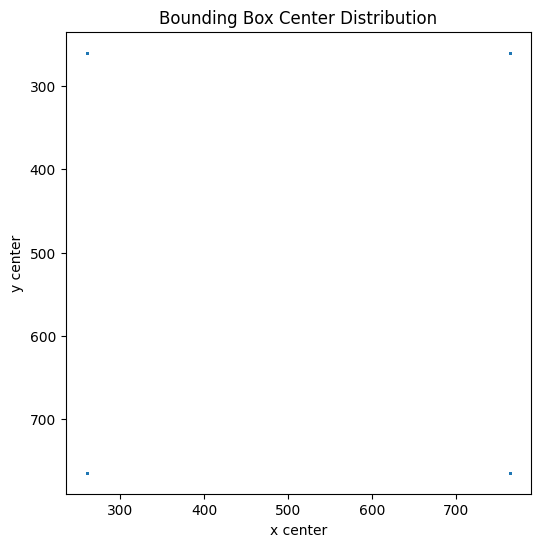

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

bboxes = pd.read_csv("/kaggle/input/solidworksnew/train_bboxes.csv")

bboxes["xc"] = (bboxes["x_min"] + bboxes["x_max"]) / 2
bboxes["yc"] = (bboxes["y_min"] + bboxes["y_max"]) / 2

plt.figure(figsize=(6,6))
plt.scatter(bboxes["xc"], bboxes["yc"], s=1, alpha=0.3)
plt.gca().invert_yaxis()
plt.title("Bounding Box Center Distribution")
plt.xlabel("x center")
plt.ylabel("y center")
plt.show()


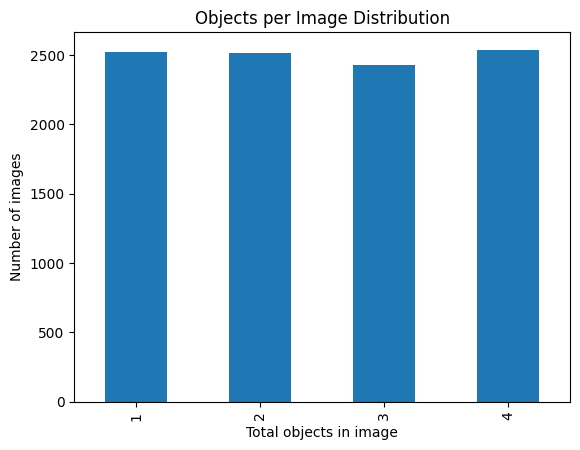

In [3]:
labels = pd.read_csv("/kaggle/input/solidworksnew/train_labels.csv")
labels["total"] = labels[["bolt","locatingpin","nut","washer"]].sum(axis=1)

labels["total"].value_counts().sort_index().plot(kind="bar")
plt.title("Objects per Image Distribution")
plt.xlabel("Total objects in image")
plt.ylabel("Number of images")
plt.show()


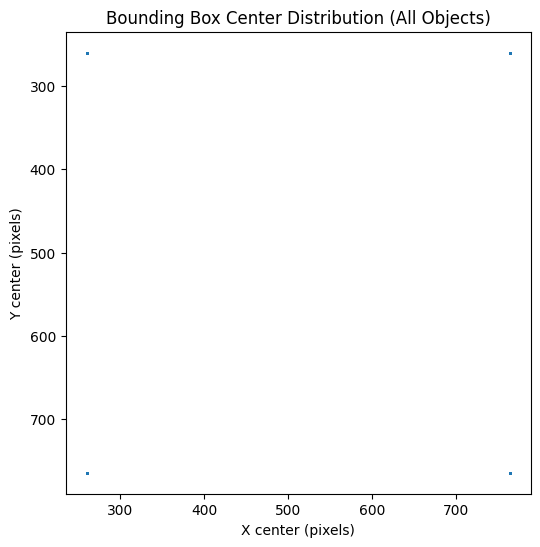

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Load bounding boxes
bboxes = pd.read_csv("/kaggle/input/solidworksnew/train_bboxes.csv")

# Compute centers
bboxes["xc"] = (bboxes["x_min"] + bboxes["x_max"]) / 2
bboxes["yc"] = (bboxes["y_min"] + bboxes["y_max"]) / 2

# Plot
plt.figure(figsize=(6,6))
plt.scatter(bboxes["xc"], bboxes["yc"], s=1, alpha=0.25)
plt.gca().invert_yaxis()
plt.title("Bounding Box Center Distribution (All Objects)")
plt.xlabel("X center (pixels)")
plt.ylabel("Y center (pixels)")
plt.show()


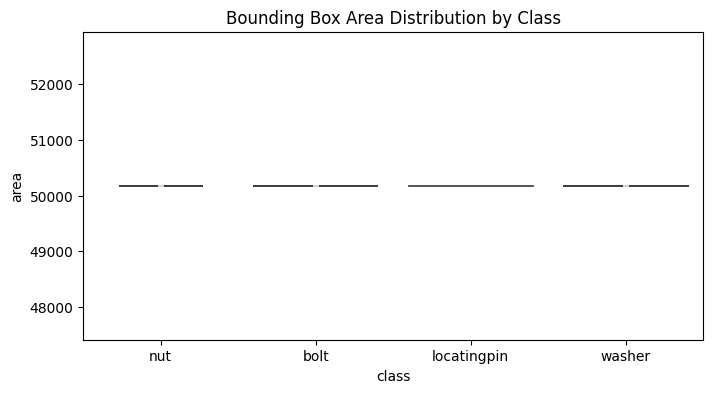

In [6]:
import seaborn as sns

bboxes["area"] = (bboxes["x_max"] - bboxes["x_min"]) * (bboxes["y_max"] - bboxes["y_min"])

plt.figure(figsize=(8,4))
sns.violinplot(x="class", y="area", data=bboxes)
plt.title("Bounding Box Area Distribution by Class")
plt.show()


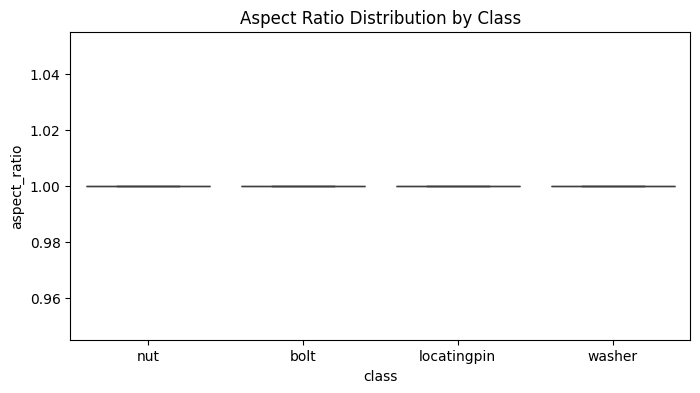

In [7]:
bboxes["width"]  = bboxes["x_max"] - bboxes["x_min"]
bboxes["height"] = bboxes["y_max"] - bboxes["y_min"]
bboxes["aspect_ratio"] = bboxes["width"] / bboxes["height"]

plt.figure(figsize=(8,4))
sns.boxplot(x="class", y="aspect_ratio", data=bboxes)
plt.title("Aspect Ratio Distribution by Class")
plt.show()


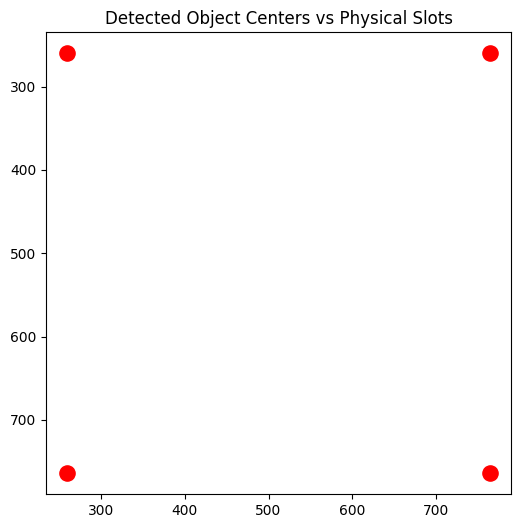

In [10]:
plt.figure(figsize=(6,6))
plt.scatter(bboxes["xc"], bboxes["yc"], s=1, alpha=0.2)

slots = [(260,260),(764,260),(260,764),(764,764)]
for x,y in slots:
    plt.scatter(x,y, c="red", s=120)

plt.gca().invert_yaxis()
plt.title("Detected Object Centers vs Physical Slots")
plt.show()


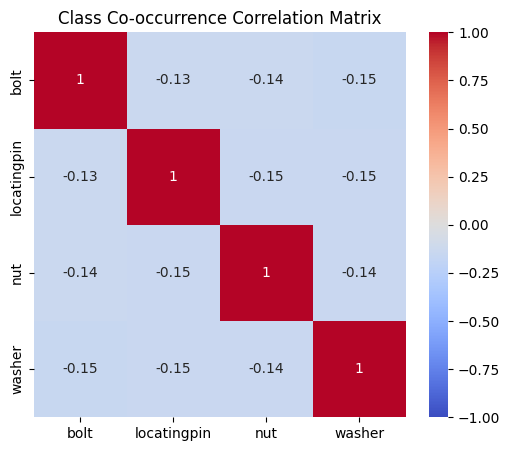

In [9]:
labels = pd.read_csv("/kaggle/input/solidworksnew/train_labels.csv")

corr = labels[["bolt","locatingpin","nut","washer"]].corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Class Co-occurrence Correlation Matrix")
plt.show()


# YOLOV8N.YAML (No weights)

In [3]:
from ultralytics import YOLO

# Architecture only (no weights)
model = YOLO("yolov8n.yaml")

model.train(
    data="/kaggle/input/solidworks-hackathon/third_dataset.yaml",
    epochs=120,
    imgsz=1024,
    batch=32,
    optimizer="SGD",
    lr0=0.01,
    momentum=0.937,
    weight_decay=5e-4,
    cos_lr=True,
    close_mosaic=10,
    patience=30,
    project="/kaggle/working",
    name="solidworks_v8n_scratch",
    save_period=10,
    device=0
)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.240 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/kaggle/input/solidworks-hackathon/third_dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=120, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a3d98481100>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

# Constraint-Aware Inference and Deterministic Prediction Generation

In [4]:
from ultralytics import YOLO

model = YOLO("/kaggle/working/solidworks_v8n_scratch/weights/best.pt") #best.pt created froms scratch

model.predict(
    source="/kaggle/input/solidworksnew/test/test",
    conf=0.15,               
    iou=0.5,
    agnostic_nms=True,       
    save_txt=True,
    project="/kaggle/working",
    name="final_strict",
    exist_ok=True
)



WARNING ⚠️ 
Inference results will accumulate in RAM unless `stream=True` is passed, which can cause out-of-memory errors for large
sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/2000 /kaggle/input/solidworksnew/test/test/0040313aa7c7478c8ca264bf573c53fe.png: 1024x1024 1 bolt, 3 locatingpins, 13.3ms
image 2/2000 /kaggle/input/solidworksnew/test/test/0080e45f4375443b96ee81dc04075117.png: 1024x1024 2 bolts, 1 washer, 13.2ms
image 3/2000 /kaggle/input/solidworksnew/test/test/0086da1a1914469caa4d042f8e4e94ef.png: 1024x1024 1 washer, 13.2ms
image 4/2000 /kaggle/input/solidworksnew/test/test/009ccd5b64a043e0afbae0f840f7cfd4.png

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'bolt', 1: 'locatingpin', 2: 'nut', 3: 'washer'}
 obb: None
 orig_img: array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        ...,
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255,

# Generate CSV for submission

In [5]:
import os
import pandas as pd

LABEL_DIR = "/kaggle/working/final_strict/labels"
IMG_SIZE = 1024

SLOTS = {
    0: (260, 260),
    1: (764, 260),
    2: (260, 764),
    3: (764, 764),
}

def nearest_slot(x, y):
    return min(SLOTS, key=lambda k: (SLOTS[k][0]-x)**2 + (SLOTS[k][1]-y)**2)

submission = []

for file in sorted(os.listdir(LABEL_DIR)):
    img = file.replace(".txt", ".png")
    slot_cls = {}

    with open(os.path.join(LABEL_DIR, file)) as f:
        for line in f:
            cls, xc, yc, w, h = map(float, line.split())
            xc *= IMG_SIZE
            yc *= IMG_SIZE
            slot = nearest_slot(xc, yc)

            
            if slot not in slot_cls:
                slot_cls[slot] = int(cls)

    counts = [0, 0, 0, 0]
    for c in slot_cls.values():
        counts[c] += 1

    submission.append([img] + counts)

df = pd.DataFrame(
    submission,
    columns=["image_name", "bolt", "locatingpin", "nut", "washer"]
)

df = df.sort_values("image_name").reset_index(drop=True)

out = "/kaggle/working/submission_strict.csv"
df.to_csv(out, index=False)

print("Saved:", out)
df.head()


Saved: /kaggle/working/submission_strict.csv


,image_name,bolt,locatingpin,nut,washer
0,0040313aa7c7478c8ca264bf573c53fe.png,1,3,0,0
1,0080e45f4375443b96ee81dc04075117.png,2,0,0,1
2,0086da1a1914469caa4d042f8e4e94ef.png,0,0,0,1
3,009ccd5b64a043e0afbae0f840f7cfd4.png,0,0,0,1
4,00a522a027b24fcfb8ee0857655b953d.png,0,1,0,0
